In [3]:
import yaml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as TVDatasets

import torch_geometric
from torch_geometric.data import Data as GraphData 

from torch_geometric.nn import GCNConv, GATConv, APPNP, SAGEConv
from torch_geometric.nn.models.label_prop import LabelPropagation
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

from sklearn.metrics import classification_report
# from sklearn.calibration import CalibrationDisplay

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib as mpl
# Use the pgf backend (must be done before import pyplot interface)
mpl.use('pgf')
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    # "text.usetex": True,     # use inline math for ticks
    # "pgf.rcfonts": False     # don't setup fonts from rc parameters
    })

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Torch is running on {device}")


import sys
from gnn_cp.data.data_manager import GraphDataManager
from gnn_cp.models.graph_models import GCN, GAT, APPNPNet, SAGE
from gnn_cp.models.model_manager import GraphModelManager
from gnn_cp.data.utils import make_dataset_instances
import gnn_cp.cp.transformations as cp_t
import gnn_cp.cp.graph_transformations as cp_gt
from gnn_cp.cp.graph_cp import GraphCP

Torch is running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda
Torch Graph Models are running on cuda


In [4]:
config_file_dir = "../baselines/config.yaml"
results_dir = "../baselines/results"
figures_dir = "./result-storage"
fair_network_results = os.path.join(figures_dir, "fair-network-results")
# if not "fair-network-results" not in os.listdir(figures_dir):
#     print("making folder")
    # os.mkdir(fair_network_results)

In [5]:
# loading the baseline settings
with open(config_file_dir, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
general_dataset_config = config.get("baseline", {}).get("general_dataset_config", {})


assert os.path.isdir(results_dir), "The results path does not exist!"

models_cache_dir = os.path.join(results_dir, "models")
assert os.path.isdir(models_cache_dir), "Directory to trained models is not found! Maybe first tun the make_baselines.py file"
data_dir = os.path.join(results_dir, "datasets")
assert os.path.isdir(data_dir), "Directory to Data Files is not found!"
splits_dir = os.path.join(results_dir, "splits")
assert os.path.isdir(splits_dir), "Directory to Data Splits is not found!"

dataset_names = list(config.get("baseline", {}).get("datasets", {}).keys())
models_config = config.get("baseline", {}).get("models", {})
model_classes = list(models_config.keys())

# Making a directory to store results for CPs
cp_results_dir = os.path.join(results_dir, "cp_results")
if not os.path.isdir(cp_results_dir):
    os.mkdir(cp_results_dir)


# region
# Making dataset-split and model instances
dataset_str_list = '\n'.join([f'{i}: {dataset_name}' for i, dataset_name in enumerate(dataset_names)])
dataset_name_idx = int(input(f"specify the dataset index:\n{dataset_str_list}\n"))
dataset_key = dataset_names[int(dataset_name_idx)]

model_str_list = '\n'.join([f'{i}: {model_name}' for i, model_name in enumerate(model_classes)])
model_class_idx = int(input(f"specify the model index:\n{model_str_list}\n"))
model_class_name = model_classes[model_class_idx]

dataset_manager = GraphDataManager(data_dir, splits_dir)
dataset = dataset_manager.get_dataset_from_key(dataset_key).data

print(f"dataset = {dataset_key}")
instances = make_dataset_instances(data_dir, splits_dir, models_cache_dir, dataset_key, model_class_name, models_config)

instances_accuracy = [instance["accuracy"] for instance in instances]
print(f"acc={np.mean(instances_accuracy)} +- {np.std(instances_accuracy)}")
best_model_accuracy = np.max(instances_accuracy)

instances_logits = [
    instance["model"].predict(dataset) for instance in instances
]

specify the dataset index:
0: cora_ml
1: pubmed
2: citeseer
3: coauthor_cs
4: coauthor_physics
5: amazon_computers
6: amazon_photo
 0
specify the model index:
0: GCN
1: GAT
2: SAGE
3: MLP
4: APPNPNet
 0


dataset = cora_ml
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644568 +- 0.009074238748131642
acc=0.8231307550644568 +- 0.009074238748131642


In [6]:
tuning_fraction = np.round(instances[0]["train_idx"].shape[0] / instances[0]["test_idx"].shape[0], 3)

lambda_vals = np.arange(0, 1.01, 0.01).round(3)
accuracy = np.max(instances_accuracy)
coverage_values = np.arange(start=accuracy.round(2), stop=0.97, step=0.01).round(3)
fixed_neigh_coef = 0.6
selected_coverage = coverage_values[len(coverage_values)//2]


def singleton_hit(pred_set, true_mask):
    one_sized_pred = (pred_set.sum(axis=1) == 1)
    result = pred_set[true_mask][one_sized_pred].sum().item() / pred_set.shape[0]
    return result

singleton_hit_metric = lambda pred_set, true_mask: singleton_hit(pred_set, true_mask)
set_size_metric = lambda pred_set, true_mask: GraphCP.average_set_size(pred_set)
coverage_metric = lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask)
argmax_accuracy = lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)

metrics_dict = {
    "empi_coverage": coverage_metric,
    "average_set_size": set_size_metric,
    "singleton_hit": singleton_hit_metric
}

k_reg_range = np.arange(0, dataset.y.max().cpu().numpy(), 1).astype(int)
penalty_range = np.arange(0, 5.01, 0.01).round(3)

pivot_coverages = np.array([(1 + best_model_accuracy * 2) / 3, (1 + best_model_accuracy) / 2, (2 + best_model_accuracy) / 3]).round(2)

In [7]:
def compute_tune_calib_fraction(instance):
    tune_fraction = np.round(instance["train_idx"].shape[0] / instance["test_idx"].shape[0], 3)
    calib_fraction = np.round(instance["train_idx"].shape[0] / (instance["test_idx"].shape[0] - instance["train_idx"].shape[0]), 3)
    return tune_fraction, calib_fraction

def tune_truetest_split(test_idx, dataset, tuning_fraction):
    te_idx, tu_idx, _, _ = dataset_manager.train_test_split(test_idx, dataset.y[test_idx], training_fraction=tuning_fraction)
    return te_idx, tu_idx

In [8]:
instance_idx = 0
instance = instances[instance_idx]

def fair_shuffle_test_multiple_metrics(
    scores, y_true_mask, coverage_guarantee=0.92,
    n_iters=10, 
    metrics_dict={"set_size": lambda pred_set, true_mask: GraphCP.average_set_size(pred_set),
                  "coverage": lambda pred_set, true_mask: GraphCP.coverage(pred_set, true_mask),
                  "argmax_accuracy": lambda pred_set, true_mask: GraphCP.argmax_accuracy(pred_set, true_mask)},
    calib_fraction=0.5, tune_scores=None, tune_mask=None):
    
    result_df = []
    for iter_idx in range(n_iters):
        iteration_series = pd.Series({"attempt": iter_idx})
        calib_scores_sub, eval_scores, calib_ymask_sub, eval_ymask = GraphDataManager.train_test_split(
            scores, y_true_mask, training_fraction=calib_fraction, return_idx=False)
        calib_scores = calib_scores_sub if tune_scores is None else torch.concat([calib_scores_sub, tune_scores])
        calib_ymask = calib_ymask_sub if tune_mask is None else torch.concat([calib_ymask_sub, tune_mask])
        scores_quantile = GraphCP(transformation_sequence=[], coverage_guarantee=coverage_guarantee).calibrate_from_scores(calib_scores, calib_ymask)
        pred_set = eval_scores > scores_quantile
        for metric_name, metric_func in metrics_dict.items():
            result_val = metric_func(pred_set, eval_ymask)
            iteration_series[metric_name] = result_val
        result_df.append(iteration_series)

    result_df = pd.DataFrame(result_df)
    return result_df

# preparing first ingrediant of CP
def compare_cps(instance, dataset, coverage_val, lambda_val, lambda_v1, lambda_v2, k_reg, penalty, calib_fraction, true_test_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt")
            ], axis=1, keys=["Baseline", "Regular", "Mixed"]
        ).T], axis=1, keys=["mean", "std"])
    return res

instance_idx = 0
instance = instances[instance_idx]


# preparing first ingrediant of CP
def compare_cps_fair(instance, dataset, coverage_val, lambda_val, lambda_v1, lambda_v2, k_reg, penalty, alpha, calib_fraction, true_test_idx, tune_idx, n_iters=100):
    train_idx, val_idx, _ = instance["train_idx"], instance["val_idx"], instance["test_idx"]
    test_idx = true_test_idx
    model = instance["model"]
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instance)
    label_mask = F.one_hot(dataset.y).bool()
    logits = model.predict(dataset, return_embeddings=True)

    baseline_cp = GraphCP(transformation_sequence=[cp_t.APSTransformation(softmax=True)])

    baseline_scores = baseline_cp.get_scores_from_logits(logits)
    baseline_result = fair_shuffle_test_multiple_metrics(baseline_scores[test_idx], label_mask[test_idx], 
                                                         coverage_guarantee=coverage_val,metrics_dict=metrics_dict, 
                                                         calib_fraction=calib_fraction, n_iters=n_iters, 
                                                         tune_scores=baseline_scores[tune_idx], tune_mask=label_mask[tune_idx])

    regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
    regular_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(regular_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    mixed_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_val, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)
    
    double_mixed_scores = cp_gt.KHopVertexMPTransformation(hop_coefs=[1 - lambda_v1 - lambda_v2, lambda_v1, lambda_v2], edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    double_mixed_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(double_mixed_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    appnp_scores = cp_gt.PPRCVertexMPTransformation(alpha=alpha, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
    appnp_result = GraphCP([], coverage_guarantee=coverage_val).shuffle_test_multiple_metrics(appnp_scores[test_idx], label_mask[test_idx], metrics_dict=metrics_dict, calib_fraction=calib_fraction, n_iters=n_iters)

    

    res = pd.concat([
        pd.concat(
            [
                baseline_result.mean().drop("attempt"),
                regular_result.mean().drop("attempt"),
                mixed_result.mean().drop("attempt"),
                double_mixed_result.mean().drop("attempt"),
                appnp_result.mean().drop("attempt"),
            ], axis=1, keys=["Baseline", "Regular", "Mixed", "DoubleMixed", "APPNP"]
        ).T, 
        pd.concat(
            [
                baseline_result.std().drop("attempt"),
                regular_result.std().drop("attempt"),
                mixed_result.std().drop("attempt"),
                double_mixed_result.std().drop("attempt"),
                appnp_result.std().drop("attempt"),
            ], axis=1, keys=["Baseline", "Regular", "Mixed", "DoubleMixed", "APPNP"]
        ).T], axis=1, keys=["mean", "std"])
    return res

In [9]:
selected_coverage=0.92
k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

def find_all_regular_params(instance, dataset, coverage_val, tune_idx, n_iterations=20):
    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 1.5])
    
    logit = instance["model"].predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    
    iteration_results = []
    overal_regular_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_sets = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overal_regular_results = [{"k_reg": 0, "penalty": 0, "average_set_size": base_cp.average_set_size(baseline_pred_sets)}]
        for k_reg in k_regs:
            for penalty in penalties:
                regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
                cp = GraphCP([], coverage_guarantee=selected_coverage)

                cp.calibrate_from_scores(regular_scores[tune_idx], label_mask[tune_idx])
                pred_set = cp.predict_from_scores(regular_scores[tune_idx])
                # print(cp.average_set_size(pred_set))

                overal_regular_results.append({
                    "k_reg": k_reg, "penalty": penalty,
                    "average_set_size": cp.average_set_size(pred_set)
                })
        overal_regular_results = pd.DataFrame(overal_regular_results)
        baseline_res = overal_regular_results.loc[(overal_regular_results["k_reg"] == 0) & (overal_regular_results["penalty"] == 0)]["average_set_size"].values[0]
        overal_regular_results["enhancement"] = overal_regular_results["average_set_size"] - baseline_res
        iteration_results.append(overal_regular_results[["enhancement"]])
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overal_regular_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["k_reg"], best_param_sets["penalty"])
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["k_reg"], best_param_series["penalty"])
    return overal_regular_results, best_params

def find_all_mixing_params(instance, dataset, coverage_val, tune_idx, n_iterations=20):
    lambda_vals = np.arange(0.05, 1, 0.05).round(3)
    logit = instance["model"].predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    test_label_mask = label_mask[tune_idx]

    iteration_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_set = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overall_mixing_results = [{"lambda": 0, "average_set_size": base_cp.average_set_size(baseline_pred_set)}]
        for lambda_v in lambda_vals:
            mixing_scores = cp_gt.VertexMPTransformation(neigh_coef=lambda_v, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
            cp = regular_result = GraphCP([], coverage_guarantee=selected_coverage)

            cp.calibrate_from_scores(mixing_scores[tune_idx], label_mask[tune_idx])
            pred_set = cp.predict_from_scores(mixing_scores[tune_idx])
                # print(cp.average_set_size(pred_set))
            overall_mixing_results.append({
                "lambda": lambda_v,
                "average_set_size": cp.average_set_size(pred_set)
            })

        overall_mixing_results = pd.DataFrame(overall_mixing_results)
        baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
        overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
        iteration_results.append(overall_mixing_results[["enhancement"]])
        
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overall_mixing_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["lambda"], )
    #     baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
    #     overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["lambda"],)
    return overall_mixing_results, best_params

def find_all_appnp_params(instance, dataset, coverage_val, tune_idx, n_iterations=20):
    alpha_vals = np.arange(0.05, 0.95, 0.1).round(3)
    logit = instance["model"].predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    test_label_mask = label_mask[tune_idx]

    iteration_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_set = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overall_mixing_results = [{"alpha": 0, "average_set_size": base_cp.average_set_size(baseline_pred_set)}]
        for alpha in alpha_vals:
            print("alpha = ", alpha)
            mixing_scores = cp_gt.PPRCVertexMPTransformation(alpha=alpha, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
            cp = regular_result = GraphCP([], coverage_guarantee=selected_coverage)

            cp.calibrate_from_scores(mixing_scores[tune_idx], label_mask[tune_idx])
            pred_set = cp.predict_from_scores(mixing_scores[tune_idx])
                # print(cp.average_set_size(pred_set))
            overall_mixing_results.append({
                "alpha": alpha,
                "average_set_size": cp.average_set_size(pred_set)
            })

        overall_mixing_results = pd.DataFrame(overall_mixing_results)
        baseline_res = overall_mixing_results.loc[(overall_mixing_results["alpha"] == 0)]["average_set_size"].values[0]
        overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
        iteration_results.append(overall_mixing_results[["enhancement"]])
        
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overall_mixing_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["alpha"], )
    #     baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
    #     overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["lambda"],)
    return overall_mixing_results, best_params


def find_all_twohop_mixing_params(instance, dataset, coverage_val, tune_idx, n_iterations=20):
    lambda_vals = np.arange(0.05, 1, 0.1).round(3)
    logit = instance["model"].predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    test_label_mask = label_mask[tune_idx]

    iteration_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.APSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        base_cp.calibrate_from_scores(baseline_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_set = base_cp.predict_from_scores(baseline_scores[tune_idx])

        overall_mixing_results = [{"lambda1": 0, "lambda2":0, "average_set_size": base_cp.average_set_size(baseline_pred_set)}]
        for lambda_v in lambda_vals:
            for lambda_v2 in lambda_vals:
                mixing_scores = cp_gt.KHopVertexMPTransformation(hop_coefs=[1 - lambda_v - lambda_v2, lambda_v, lambda_v2], 
                                                                 edge_index=dataset.edge_index,
                                                                 n_vertices=dataset.x.shape[0]).pipe_transform(baseline_scores)
                cp = regular_result = GraphCP([], coverage_guarantee=selected_coverage)

                cp.calibrate_from_scores(mixing_scores[tune_idx], label_mask[tune_idx])
                pred_set = cp.predict_from_scores(mixing_scores[tune_idx])
                    # print(cp.average_set_size(pred_set))
                overall_mixing_results.append({
                    "lambda1": lambda_v,
                    "lambda2": lambda_v2,
                    "average_set_size": cp.average_set_size(pred_set)
                })

        overall_mixing_results = pd.DataFrame(overall_mixing_results)
        baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda1"] == 0) & (overall_mixing_results["lambda2"] == 0)]["average_set_size"].values[0]
        overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
        iteration_results.append(overall_mixing_results[["enhancement"]])
        
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overall_mixing_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["lambda1"], best_param_sets["lambda2"])
    #     baseline_res = overall_mixing_results.loc[(overall_mixing_results["lambda"] == 0)]["average_set_size"].values[0]
    #     overall_mixing_results["enhancement"] = overall_mixing_results["average_set_size"] - baseline_res
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["lambda"],)
    return overall_mixing_results, best_params

In [10]:
selected_dataset="cora_ml"
selected_coverage=0.92
coverage_mode="fixed"
coverage_ratio=0.66

In [11]:
def get_dataset_model_result(selected_dataset, selected_model, selected_coverage, coverage_mode="fixed", coverage_ratio=0.66, fair_mode=True, alpha=0.85):
    dataset = dataset_manager.get_dataset_from_key(selected_dataset).data
    # for selected_model in model_classes:
    models_results = []
    if fair_mode:
        print("Computing Results in Fair Mode")
    
        # make dataset instances
    instances = make_dataset_instances(data_dir, splits_dir, models_cache_dir, selected_dataset, selected_model, models_config)
    tune_fraction, calib_fraction = compute_tune_calib_fraction(instances[0])
    tune_idxs = []
    test_idxs = []
    for instance in instances:
        tune_idx, test_idx = tune_truetest_split(instance["test_idx"], dataset, tune_fraction)
        tune_idxs.append(tune_idx)
        test_idxs.append(test_idx)

    if coverage_mode == "adaptive":
        mean_acc = np.mean([instance["accuracy"] for instance in instances])
        selected_coverage = coverage_ratio * 1.0 + (1 - coverage_ratio) * mean_acc
        selected_coverage = round(selected_coverage, 3)
        print(f"adaptive coverage with 1 - alpha = {selected_coverage} - Dataset = {selected_dataset}")

    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0])

    instance_results = []
    for instance_idx, instance in enumerate(instances):
        tune_idx = tune_idxs[instance_idx]
        test_idx = test_idxs[instance_idx]
        reg_enhancement, reg_params = find_all_regular_params(
            instance, dataset, selected_coverage, tune_idx, n_iterations=20)

        best_k_reg = reg_params[0]
        best_penalty = reg_params[1]
        print("reg params", reg_params)

        mixing_enhancement, mixing_params = find_all_mixing_params(
            instance, dataset, selected_coverage, tune_idx, n_iterations=20)
        lambda_val = mixing_params[0]
        print("mixing params", mixing_params)
        
        double_mixing_enhancement, double_mixing_params = find_all_twohop_mixing_params(
            instance, dataset, selected_coverage, tune_idx, n_iterations=20)
        lambda_v1, lambda_v2 = double_mixing_params
        print("double mixing params", double_mixing_params)

        if fair_mode:
            res_combined = compare_cps_fair(
                instance, dataset, selected_coverage, lambda_val=lambda_val, lambda_v1=lambda_v1, lambda_v2=lambda_v2,
                k_reg=best_k_reg, penalty=best_penalty, alpha=alpha, true_test_idx=test_idx, calib_fraction=calib_fraction, tune_idx=tune_idx)
        else:
            res_combined = compare_cps(
                instance, dataset, selected_coverage, lambda_val=lambda_val, 
                k_reg=best_k_reg, penalty=best_penalty, true_test_idx=test_idx, calib_fraction=calib_fraction)

        res = res_combined["mean"]
        res_sd = res_combined["std"]

        instance_results.append(res)
    instance_results = pd.concat(instance_results, axis=0, keys=[idx for idx in range(len(instances))])
    instance_mean_results = instance_results.reset_index().rename(
        columns={"level_0": "instance", "level_1": "method"})
    return instance_mean_results

In [12]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = 0
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )
    line.set_alpha(0.4)

def pareto_plot(result_plot, ax, points_coordinate_name="model", annotate_points=False):
    sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
    sns.scatterplot(data=result_plot, x="singleton_hit", y="average_set_size", hue="method", ax=ax, s=160)

    for idx in result_plot[points_coordinate_name].unique():
        to_point = lambda row: (row["singleton_hit"].values[0], row["average_set_size"].values[0])
        baseline_select = lambda x: x["method"] == "Baseline" and x[points_coordinate_name] == idx
        regular_select = lambda x: x["method"] == "Regular" and x[points_coordinate_name] == idx
        mixed_select = lambda x: x["method"] == "Mixed" and x[points_coordinate_name] == idx
        baseline_point = to_point(result_plot[result_plot.apply(baseline_select, axis=1)])
        regular_point = to_point(result_plot[result_plot.apply(regular_select, axis=1)])
        mixed_point = to_point(result_plot[result_plot.apply(mixed_select, axis=1)])

        reg_line = ax.plot([baseline_point[0], regular_point[0]], [baseline_point[1], regular_point[1]], color="orange", alpha=0.5)[0]
        mix_line = ax.plot([baseline_point[0], mixed_point[0]], [baseline_point[1], mixed_point[1]], color="green", alpha=0.5)[0]
        # add_arrow(reg_line, size=20)
        # add_arrow(mix_line, size=20)
        ax.legend(loc="upper right")

        if annotate_points:
            ax.annotate(f"{idx}", baseline_point, fontsize=10)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)

    ax.set_xlabel("Singleton hit")
    ax.set_ylabel("Effective set size")
    return result_plot

In [13]:
selected_dataset = "cora_ml"
model = "GCN"

tune_fraction, calib_fraction = compute_tune_calib_fraction(instances[0])
tune_idxs = []
test_idxs = []
for instance in instances:
    tune_idx, test_idx = tune_truetest_split(instance["test_idx"], dataset, tune_fraction)
    tune_idxs.append(tune_idx)
    test_idxs.append(test_idx)
    
tune_idx = tune_idxs[0]
test_idx = test_idxs[0]

In [15]:
appnp_tuning, appnp_params = find_all_appnp_params(instances[0], dataset, 0.92, tune_idx, n_iterations=5)
appnp_params

alpha =  0.05
alpha =  0.15
alpha =  0.25
alpha =  0.35
alpha =  0.45
alpha =  0.55
alpha =  0.65
alpha =  0.75
alpha =  0.85
alpha =  0.05
alpha =  0.15
alpha =  0.25
alpha =  0.35
alpha =  0.45
alpha =  0.55
alpha =  0.65
alpha =  0.75
alpha =  0.85
alpha =  0.05
alpha =  0.15
alpha =  0.25
alpha =  0.35
alpha =  0.45
alpha =  0.55
alpha =  0.65
alpha =  0.75
alpha =  0.85
alpha =  0.05
alpha =  0.15
alpha =  0.25
alpha =  0.35
alpha =  0.45
alpha =  0.55
alpha =  0.65
alpha =  0.75
alpha =  0.85
alpha =  0.05
alpha =  0.15
alpha =  0.25
alpha =  0.35
alpha =  0.45
alpha =  0.55
alpha =  0.65
alpha =  0.75
alpha =  0.85


(0.85,)

<AxesSubplot:xlabel='alpha', ylabel='average_set_size'>

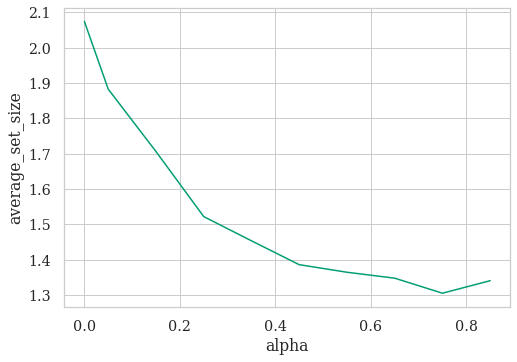

In [19]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
f, ax = plt
sns.lineplot(data=appnp_tuning, x="alpha", y="average_set_size", color="#029E73")


In [13]:
selected_dataset = "cora_ml"
selected_model = "GCN"
selected_coverage=0.92
overall_result = get_dataset_model_result(selected_dataset, selected_model, selected_coverage, coverage_mode="fixed", coverage_ratio=0.66, fair_mode=True, alpha=0.85)

Computing Results in Fair Mode
Dataset Loaded Successfully!
Following labeled splits:
class 0: train=20, val=20
class 1: train=20, val=20
class 2: train=20, val=20
class 3: train=20, val=20
class 4: train=20, val=20
class 5: train=20, val=20
class 6: train=20, val=20
Loading Models
Loading Models GCN
Accuracy: 0.8231307550644565 +- 0.009074238748131642
reg params (0.0, 0.5)
mixing params (0.55,)
double mixing params (0.35, 0.55)
reg params (0.0, 0.5)
mixing params (0.4,)
double mixing params (0.15, 0.35)
reg params (0.0, 0.5)
mixing params (0.6,)
double mixing params (0.55, 0.25)
reg params (0.0, 0.01)
mixing params (0.45,)
double mixing params (0.45, 0.15)
reg params (0.0, 0.5)
mixing params (0.25,)
double mixing params (0.05, 0.55)
reg params (0.0, 0.1)
mixing params (0.5,)
double mixing params (0.35, 0.05)
reg params (0.0, 0.5)
mixing params (0.55,)
double mixing params (0.25, 0.35)
reg params (0.0, 0.1)
mixing params (0.5,)
double mixing params (0.35, 0.15)
reg params (0.0, 0.2)
mi

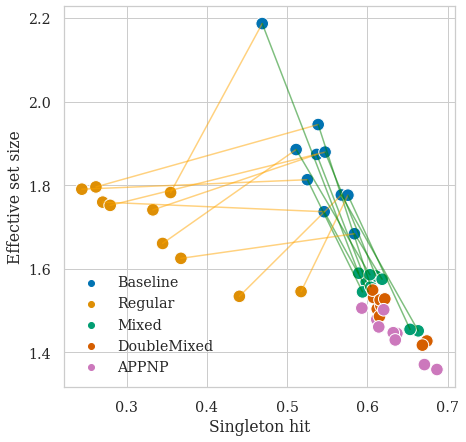

In [78]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = pareto_plot(overall_result, ax, points_coordinate_name="instance", annotate_points=False)

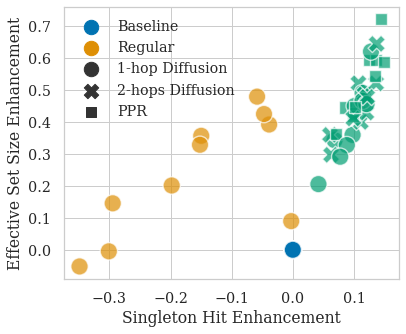

In [23]:
sns.set_theme(context='notebook', style='whitegrid', palette='colorblind', font='serif', font_scale=1.3, color_codes=True, rc=None)
result_df = overall_result
result_df["coverage"] = 0.92
result_df["baseline_set_size"] = result_df.apply(
    lambda row: result_df.loc[(result_df["instance"] == row["instance"]) & (result_df["method"] == "Baseline"), "average_set_size"
                             ].values[0], axis=1)
result_df["average_set_size_enhancement"] = result_df["baseline_set_size"] - result_df["average_set_size"]


result_df["baseline_singleton_hit"] = result_df.apply(
    lambda row: result_df.loc[(result_df["instance"] == row["instance"]) & (result_df["method"] == "Baseline"), "singleton_hit"
                             ].values[0], axis=1)
result_df["singleton_hit_enhancment"] = result_df["singleton_hit"] - result_df["baseline_singleton_hit"]

f, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.scatterplot(data=result_df.loc[(result_df["method"] == "Baseline") | ((result_df["method"] == "Regular"))], x="singleton_hit_enhancment", 
                y="average_set_size_enhancement", hue="method", 
                s=300, alpha=0.7, ax=ax)
sns.scatterplot(data=result_df.loc[~(result_df["method"] == "Baseline") & ~((result_df["method"] == "Regular"))], x="singleton_hit_enhancment", 
                y="average_set_size_enhancement", color="#029E73", style="method",
                s=300, alpha=0.7, ax=ax)
ax.set_ylabel("Effective Set Size Enhancement")
ax.set_xlabel("Singleton Hit Enhancement")
handles, labels = ax.get_legend_handles_labels()
labels[2]="1-hop Diffusion"
labels[3]="2-hops Diffusion"
labels[4]="PPR"

ax.legend(handles[:6], labels[:6], markerscale=2.4)

plt.savefig(os.path.join(figures_dir, "generalizations2.pgf"), format="pgf", bbox_inches='tight')

In [94]:
def find_all_prob_normal_regular_params(instance, dataset, coverage_val, tune_idx, n_iterations=20):
    k_regs = np.arange(0, dataset.y.max().cpu().numpy() + 1, 1).astype(int)
    penalties = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1.0, 1.5])
    
    logit = instance["model"].predict(dataset)
    label_mask = F.one_hot(dataset.y).bool()
    
    iteration_results = []
    overal_regular_results = []
    for iteration in range(n_iterations):
        baseline_scores = cp_t.TPSTransformation(softmax=True).pipe_transform(logit)
        base_cp = GraphCP([], coverage_guarantee=selected_coverage)
        
        baseline_aps_scores = cp_t.APSTransformation(softmax=False).pipe_transform(baseline_scores)
        base_cp.calibrate_from_scores(baseline_aps_scores[tune_idx], label_mask[tune_idx])
        baseline_pred_sets = base_cp.predict_from_scores(baseline_aps_scores[tune_idx])

        overal_regular_results = [{"k_reg": 0, "penalty": 0, "average_set_size": base_cp.average_set_size(baseline_pred_sets)}]
        for k_reg in k_regs:
            for penalty in penalties:
                regular_scores = cp_t.RegularizerPenalty(k_reg=k_reg, penalty=penalty).pipe_transform(baseline_scores)
                prob_normal_scores = cp_t.RowProbNormal().pipe_transform(regular_scores)
                prob_raps_scores = cp_t.APSTransformation(softmax=False).pipe_transform(prob_normal_scores)
                
                cp = GraphCP([], coverage_guarantee=selected_coverage)

                cp.calibrate_from_scores(prob_raps_scores[tune_idx], label_mask[tune_idx])
                pred_set = cp.predict_from_scores(prob_raps_scores[tune_idx])
                # print(cp.average_set_size(pred_set))

                overal_regular_results.append({
                    "k_reg": k_reg, "penalty": penalty,
                    "average_set_size": cp.average_set_size(pred_set)
                })
        overal_regular_results = pd.DataFrame(overal_regular_results)
        baseline_res = overal_regular_results.loc[(overal_regular_results["k_reg"] == 0) & (overal_regular_results["penalty"] == 0)]["average_set_size"].values[0]
        overal_regular_results["enhancement"] = overal_regular_results["average_set_size"] - baseline_res
        iteration_results.append(overal_regular_results[["enhancement"]])
    iteration_results = pd.concat(iteration_results, axis=1)
    iteration_mean = iteration_results.mean(axis=1)
    best_param_sets = overal_regular_results.loc[iteration_mean.idxmin()]
    best_params = (best_param_sets["k_reg"], best_param_sets["penalty"])
    # best_param_series = res.loc[res["average_set_size"].idxmin()]
    # best_params = (best_param_series["k_reg"], best_param_series["penalty"])
    return overal_regular_results, best_params

In [117]:
prob_raps_enhancement, prob_raps_params = find_all_prob_normal_regular_params(instances[0], dataset, 0.92, instances[0]["test_idx"], n_iterations=20)
normal_raps_enhancement, normal_raps_params = find_all_regular_params(instances[0], dataset, 0.92, instances[0]["test_idx"], n_iterations=20)

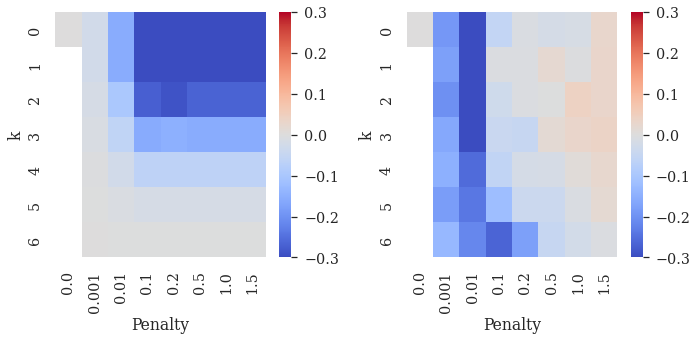

In [176]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(normal_raps_enhancement.pivot("k_reg", "penalty")["enhancement"], cmap="coolwarm", vmax=0.3, vmin=-0.3, ax=axs[0])
sns.heatmap(prob_raps_enhancement.pivot("k_reg", "penalty")["enhancement"], cmap="coolwarm", vmax=0.3, vmin=-0.3, ax=axs[1])

axs[0].set_ylabel("k")
axs[0].set_xlabel("Penalty")
axs[1].set_ylabel("k")
axs[1].set_xlabel("Penalty")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, "raps_param_pathways.pgf"), format="pgf", bbox_inches='tight')

In [170]:
k_reg = 0
penalty = 1.7
lambda_val = 0.7

self_prob_coef = "random"
logits = instances[0]["model"].predict(dataset)
test_idx = instances[0]["test_idx"]
true_mask = F.one_hot(dataset.y[test_idx]).bool()


base_cp = GraphCP(transformation_sequence=[cp_t.TPSTransformation(softmax=True), cp_t.RowProbNormal(), cp_t.APSTransformation(softmax=False, self_prob_coef=self_prob_coef)])
baseline_scores = base_cp.get_scores_from_logits(logits, test_idx=test_idx)
baseline_result = base_cp.shuffle_metrics_over_coverage(baseline_scores, true_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

raps_cp = GraphCP(transformation_sequence=[cp_t.TPSTransformation(softmax=True), cp_t.RowProbNormal(), cp_t.APSTransformation(softmax=False, self_prob_coef=self_prob_coef), cp_t.RegularizerPenalty(k_reg=normal_raps_params[0], panalty=normal_raps_params[1])])
raps_scores = raps_cp.get_scores_from_logits(logits, test_idx=test_idx)
raps_result = raps_cp.shuffle_metrics_over_coverage(raps_scores, true_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

true_raps_cp = GraphCP(transformation_sequence=[cp_t.TPSTransformation(softmax=True), cp_t.RegularizerPenalty(k_reg=prob_raps_params[0], panalty=prob_raps_params[1]), cp_t.RowProbNormal(), cp_t.APSTransformation(softmax=False, self_prob_coef=self_prob_coef)])
true_raps_scores = true_raps_cp.get_scores_from_logits(logits, test_idx=test_idx)
true_raps_result = true_raps_cp.shuffle_metrics_over_coverage(true_raps_scores, true_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

mixing_cp = GraphCP(transformation_sequence=[cp_t.TPSTransformation(softmax=True), cp_t.RowProbNormal(), cp_t.APSTransformation(softmax=False, self_prob_coef=self_prob_coef), cp_gt.VertexMPTransformation(neigh_coef=0.6, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0])])
normal_mixing_scores = mixing_cp.get_scores_from_logits(logits, test_idx=test_idx)
normal_mixing_result = mixing_cp.shuffle_metrics_over_coverage(normal_mixing_scores, true_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)

true_mixing_cp = GraphCP(transformation_sequence=[cp_t.TPSTransformation(softmax=True), cp_gt.VertexMPTransformation(neigh_coef=0.7, edge_index=dataset.edge_index, n_vertices=dataset.x.shape[0]), cp_t.APSTransformation(softmax=False, self_prob_coef=self_prob_coef)])
true_normal_mixing_scores = true_mixing_cp.get_scores_from_logits(logits, test_idx=test_idx)
true_normal_mixing_result = true_mixing_cp.shuffle_metrics_over_coverage(true_normal_mixing_scores, true_mask, coverage_values, metrics_dict=metrics_dict, calib_fraction=calib_fraction)


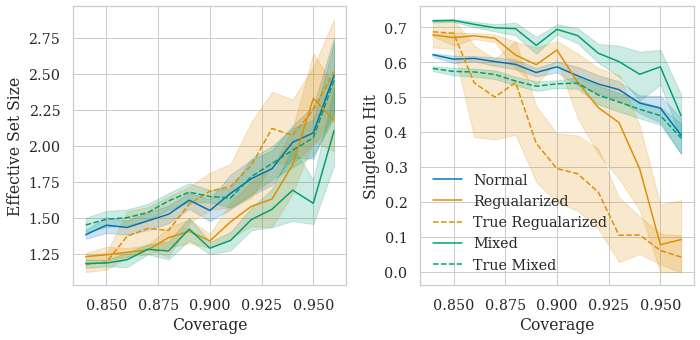

In [177]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=baseline_result, x="coverage_guarantee", y="average_set_size", ax=axs[0], label="Normal", color="#0173B2")
sns.lineplot(data=raps_result, x="coverage_guarantee", y="average_set_size", ax=axs[0], label="Regualarized", color="#DE8F05")
sns.lineplot(data=true_raps_result, x="coverage_guarantee", y="average_set_size", ax=axs[0], label="True Regualarized", color="#DE8F05", linestyle="--")
sns.lineplot(data=normal_mixing_result, x="coverage_guarantee", y="average_set_size", ax=axs[0], label="Mixed", color="#029E73")
sns.lineplot(data=true_normal_mixing_result, x="coverage_guarantee", y="average_set_size", ax=axs[0], label="True Mixed", color="#029E73", linestyle="--")

sns.lineplot(data=baseline_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1], label="Normal", color="#0173B2")
sns.lineplot(data=raps_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1], label="Regualarized", color="#DE8F05")
sns.lineplot(data=true_raps_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1], label="True Regualarized", color="#DE8F05", linestyle="--")
sns.lineplot(data=normal_mixing_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1], label="Mixed", color="#029E73")
sns.lineplot(data=true_normal_mixing_result, x="coverage_guarantee", y="singleton_hit", ax=axs[1], label="True Mixed", color="#029E73", linestyle="--")

axs[0].legend().remove()
# axs[1].legend().remove()

axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage")

axs[0].set_ylabel("Effective Set Size")
axs[1].set_ylabel("Singleton Hit")

plt.tight_layout()

plt.savefig(os.path.join(figures_dir, "prob_pathways.pgf"), format="pgf", bbox_inches='tight')